How to check your model

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, y = datasets.make_classification(n_samples=100000, n_features=20, n_informative=7, n_redundant=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.99, random_state=42)

In [2]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(C=1, solver="lbfgs")
svc = SVC(max_iter=10000, probability=True)

In [3]:
probs_lgr = lgr.fit(X_train, y_train).predict_proba(X_test)[:, 1]
preds_svc = svc.fit(X_train, y_train).predict(X_test)

probs_svc = svc.decision_function(X_test)
probs_svc = (probs_svc - probs_svc.min()) / (probs_svc.max() - probs_svc.min())

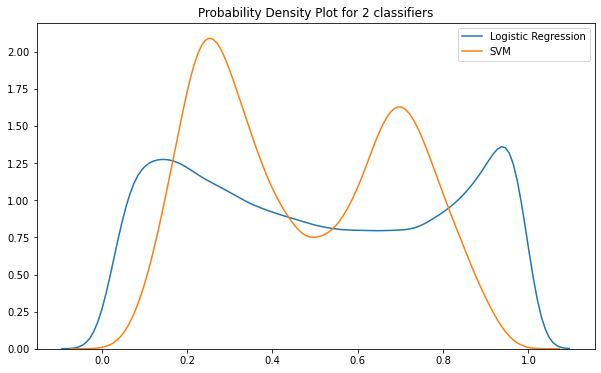

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.kdeplot(probs_lgr, label="Logistic Regression")
sns.kdeplot(probs_svc, label="SVM")
plt.title("Probability Density Plot for 2 classifiers")
plt.show()

The AUC-ROC curve for the two models.

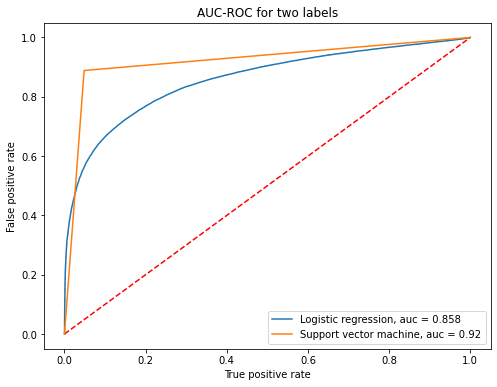

In [12]:
from sklearn import metrics

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], '--r')

pred = probs_lgr
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'Logistic regression, auc = {str(round(auc, 3))}')

pred = preds_svc
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'Support vector machine, auc = {str(round(auc, 3))}')

plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('AUC-ROC for two labels')
plt.legend()
plt.show()

Calibration curve function to plot each of the models.

In [16]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

Logistic regression calibration curve.

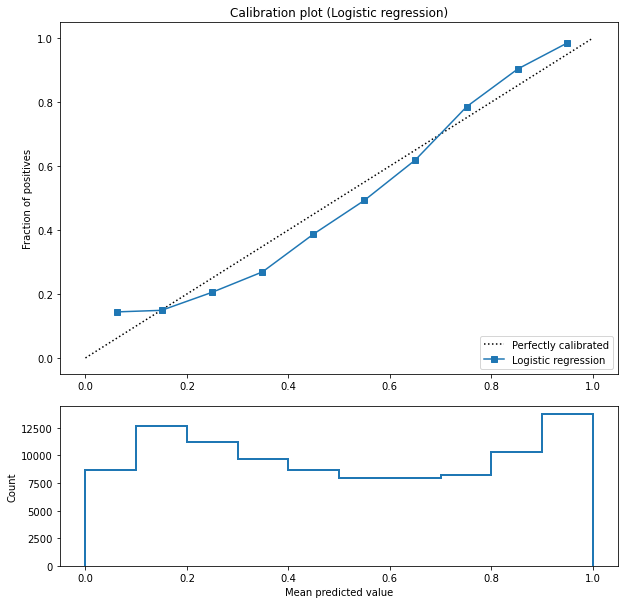

In [17]:
plot_calibration_curve("Logistic regression", 1, probs_lgr)

SVM calibration curve.

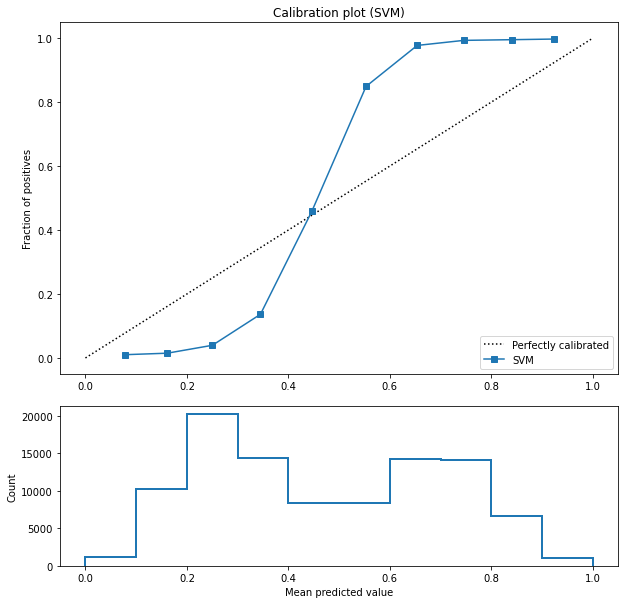

In [18]:
plot_calibration_curve("SVM", 1, probs_svc)

CALIBRATING THE MODEL

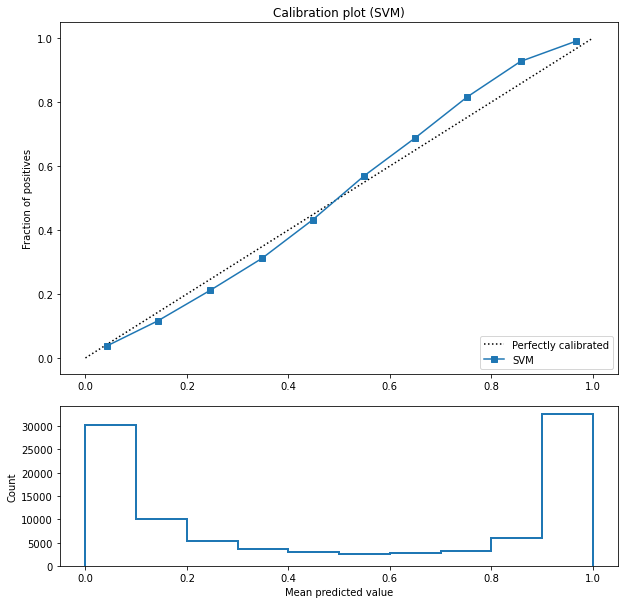

In [20]:
from sklearn.calibration import CalibratedClassifierCV

lgr = LogisticRegression(C=1, solver="lbfgs")
svc = SVC(max_iter=10000, probability=True)

platts_scaling = CalibratedClassifierCV(svc, cv=2, method='sigmoid')
platts_scaling.fit(X_train, y_train)
calibrated_probs = platts_scaling.predict_proba(X_test)[:, 1]

plot_calibration_curve("SVM", 3, calibrated_probs)